# Inverting gradient attack

We run the inverting gradient data poisoning attack by [Bouaziz et al.](https://arxiv.org/abs/2410.21453) We compare the effectiveness of machine unlearning as a defense, with a robust gradient aggregation rule.

We consider the same machine unlearning algorithms tested by [Pawelczyk et al.](https://arxiv.org/abs/2406.17216) and we use the $m$-KRUM aggregator introduced by [Blanchard et al.](https://arxiv.org/abs/1703.02757)

## Setup

### Package installations

Run this uncommented cell below to install the required packages:

In [1]:
#%pip install numpy matplotlib scipy pandas seaborn tqdm scikit-learn SciencePlots
#%pip install torch torchvision tensorboard torchmetrics torchinfo

### Imports

In [39]:
from __future__ import annotations

from copy import deepcopy
import dataclasses
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import torch
from torch import nn, Tensor
from torch.nn.modules.loss import _Loss, CrossEntropyLoss
from torch.optim import Optimizer, SGD, Adam
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchmetrics.classification import MulticlassAccuracy
from IPython.display import clear_output

from image_classification.nn import Logs, test_epoch
from image_classification.accel import BEST_DEVICE

### Data directories

In [40]:
DATA_DIR = Path.cwd() / 'data' / 'inverting_gradient_attack_cookbook'
os.makedirs(DATA_DIR, exist_ok=True)

## Base learning settings

### Model

For quick prototyping, also consider using [`ShuffleNetV2`](https://arxiv.org/abs/1807.11164v1), a 300M-parameter model that is much smaller than [`ResNet18`](https://arxiv.org/abs/1704.06904). Experiments can be made on both models or on only one of them.

In [41]:
from image_classification.models import ResNet18, ShuffleNetV2, ConvNet16
from image_classification.datasets import cifar10_train_test, cifar100_train_test

### Dataset

We use CIFAR-10 by default.

In [42]:
# Set to 10 for CIFAR-10, 100 for CIFAR-100
num_classes = 10

# The images are already normalized by these datasets
if num_classes == 10:
    get_train_test = cifar10_train_test
elif num_classes == 100:
    get_train_test = cifar100_train_test
else:
    raise ValueError(f"Can't find CIFAR dataset with {num_classes} classes")
print(f"Loading CIFAR-{num_classes}")

training_data, test_data = get_train_test(root='data')
N_test = len(test_data)
N_val = len(training_data) // 10
N_aux = N_val
N = len(training_data) - N_val - N_aux
# This works since training data is already shuffled
training_data, val_data, aux_data = training_data.split([N, N_val, N_aux])

batch_size = 100
N, N_val, N_aux, N_test

Loading CIFAR-10


(40000, 5000, 5000, 10000)

In [43]:
train_loader = DataLoader(training_data, batch_size, drop_last=True)
test_loader = DataLoader(test_data, batch_size, drop_last=True)
val_loader = DataLoader(val_data, batch_size, drop_last=True)
# We can use a small batch size (~25) on the auxiliary dataset since the attack complexity is quadratic.
# If testing Krum, aux_loader and train_loader must have the same batch size for consistency
aux_loader = DataLoader(aux_data, batch_size, drop_last=True)

### Hyperparameters

In [44]:
criterion = CrossEntropyLoss()

## Inverting gradient attack

In [45]:
from image_classification.gradient_attack import (
    GradientAttack,
    GradientEstimator, OmniscientGradientEstimator, ShadowGradientEstimator,
    SampleInit, SampleInitRandomNoise, SampleInitFeedback, LearningSettings, GradientInverter,
    Schedule, NeverUpdate
)
from inverting_gradient_attack import Pipeline, PipelineResults, Unlearning, Hyperparams
import federated as fed
#from federated import Aggregator, Mean, Krum
from inverting_gradient_attack import Aggregator, Mean, Krum # Avoids failing isinstance checks
from federated.utils import convert_bn_modules_to_gn

## Poisoning + Unlearning pipeline

### Patch model with GroupNorm

In [46]:
def patch_network(network_factory: type[nn.Module]):
    """Patches a neural network factory to make it compatible to per-gradient backpropagation.
    
    This replaces a model's BatchNorm layers with GroupNorm.
    See `federated.utils` documentation for technical details.
    """
    def patch():
        return convert_bn_modules_to_gn(network_factory())
    
    return patch

### Evaluation

In [47]:
def compute_accuracy(model: nn.Module) -> float:
    """Compute the model accuracy on the test set."""
    metric = MulticlassAccuracy(num_classes)
    logger = test_epoch(
        model,
        test_loader,
        criterion,
        metric=metric,
    )
    return logger.metrics['MulticlassAccuracy'].compute().item()

### Pipeline

In [48]:
def run_pipeline(
        model_factory = ResNet18,
        aggregator = Mean(),
        opt_cls: type[Optimizer] = Adam,
        inversion_method: GradientAttack | None = None,
        poison_factor: float = 0.2,
        unlearning_method: Unlearning | None = None,
        training_hparams: dict = {},
        unlearning_hparams: dict = {},
        quicktesting: bool = False,
        forget_set: Dataset = None,
    ) -> tuple[nn.Module, PipelineResults]:
    """Run a training pipeline with default settings.

    The training may include poisoning with an inverting gradient attack,
    and perform unlearning after training.

    Parameters:
        model_factory (Module type): the neural network class.
        aggregator (Aggregator): a gradient aggregation method.
        inversion_method (GradientAttack, optional): the gradient inversion method.
        poison_factor (float, optional): the proportion of poisons in the training data.
        unlearning_method (Unlearning, optional): the unlearning algorithm.
        forget_set (Dataset, optional): the dataset to unlearn. Not needed if poisoning.

        training_hparams (dict, optional): training hyperparameter overrides.
        unlearning_hparams (dict, optional): unlearning hyperparameter overrides.

        quicktesting (bool, defaults to False): whether to use a small model,
            a smaller subset of the training dataset and less training epochs
            for quicker testing iterations. Overrides hyperparameters when relevant.

    Returns:
        out (tuple[nn.Module, PipelineResults]): the trained and possibly unlearned model
            and the pipeline results.
    """
    poisoning = inversion_method is not None
    unlearning = unlearning_method is not None

    if poisoning:
        inverter = GradientInverter(
            method = inversion_method,
            estimator = ShadowGradientEstimator(aux_loader),
            steps = 15,
            lr = 0.6,
            lr_decay = 0.93,
            momentum = 0.5,
            sample_init = SampleInitFeedback(aux_data),
            #sample_init = SampleInitRandomNoise(training_data),
        )
    
    settings = LearningSettings(
        criterion,
        aggregator = deepcopy(aggregator),
        num_clean = batch_size,
        num_byzantine = int(poison_factor / (1. - poison_factor) * batch_size),
    )

    hparams = Hyperparams.presets(opt_cls, model_factory)
    hparams = dataclasses.replace(hparams, batch_size=batch_size, num_classes=num_classes)
    hparams = dataclasses.replace(hparams, **training_hparams)

    if quicktesting:
        model_factory = ShuffleNetV2
        mini_train_set, _ = random_split(training_data, [0.1, 0.9])
        train_loader_ = DataLoader(mini_train_set, batch_size)
        hparams = dataclasses.replace(hparams, epochs=1)
        if poisoning:
            inverter.steps = 1
    else:
        train_loader_ = train_loader

    pipeline = Pipeline(
        settings, train_loader_, val_loader,
        opt_cls=opt_cls, hparams=hparams,
    )
    if unlearning:
        pipeline.unlearning_hparams[unlearning_method].update(unlearning_hparams)
    print(pipeline)

    model = patch_network(model_factory)().to(BEST_DEVICE)

    if poisoning and unlearning:
        unlearner, results = pipeline.poison_and_unlearn(model, inverter, unlearning_method)
        model = unlearner
    elif poisoning:
        poisoned, results = pipeline.poison(model, inverter)
        model = poisoned
    elif unlearning:
        unlearner, results = pipeline.unlearn(model, forget_set, unlearning_method)
        model = unlearner
    else:
        trained, results = pipeline.train(model)
        model = trained 
    
    return model, results

### Normal training

In [49]:
def train(
        model_factory = ResNet18,
        opt_cls: type[Optimizer] = Adam,
        aggregator = Mean(),
        training_hparams: dict = {},
        quicktesting: bool = False,
) -> tuple[nn.Module, PipelineResults]:
    """Train the model normally.
    
    See `run_pipeline` for details on the arguments.
    """
    return run_pipeline(
        model_factory,
        aggregator=aggregator,
        opt_cls=opt_cls,
        poison_factor=0.0,
        training_hparams=training_hparams,
        quicktesting=quicktesting,
    )

### Training with data poisoning

This inverting gradient data poisoning attack can be defended by changing the aggregator to KRUM.

In [50]:
def poison(
        model_factory = ResNet18,
        opt_cls: type[Optimizer] = Adam,
        aggregator = Mean(),
        inversion_method = GradientAttack.ASCENT,
        poison_factor: float = 0.2,
        training_hparams: dict = {},
        quicktesting: bool = False,
    ) -> tuple[nn.Module, PipelineResults]:
    """Run the poisoning pipeline with default settings.

    See `run_pipeline` for details on the arguments.
    """
    return run_pipeline(
        model_factory,
        aggregator=aggregator,
        opt_cls=opt_cls,
        inversion_method=inversion_method,
        poison_factor=poison_factor,
        training_hparams=training_hparams,
        quicktesting=quicktesting,
    )

### Poisoning and then Unlearning

Machine unlearning is used against a gradient inversion data poisoning attack.

In [51]:
def poison_and_unlearn(
        model_factory = ResNet18,
        aggregator = Mean(),
        opt_cls: type[Optimizer] = Adam,
        inversion_method = GradientAttack.ASCENT,
        poison_factor: float = 0.2,
        unlearning_method = Unlearning.NEG_GRAD_PLUS,
        training_hparams: dict = {},
        unlearning_hparams: dict = {},
        quicktesting: bool = False,
    ) -> tuple[nn.Module, PipelineResults]:
    """Run the poison-and-unlearn pipeline with default settings.

    See `run_pipeline` for details on the arguments.
    """
    return run_pipeline(
        model_factory,
        aggregator=aggregator,
        opt_cls=opt_cls,
        inversion_method=inversion_method,
        poison_factor=poison_factor,
        unlearning_method=unlearning_method,
        training_hparams=training_hparams,
        unlearning_hparams=unlearning_hparams,
        quicktesting=quicktesting,
    )

### Just unlearn

In [52]:
def unlearn(
        model: nn.Module,
        forget_set: Dataset,
        aggregator = Mean(),
        opt_cls: type[Optimizer] = Adam,
        unlearning_method = Unlearning.NEG_GRAD_PLUS,
        unlearning_hparams: dict = {},
        quicktesting: bool = False,
    ) -> tuple[nn.Module, PipelineResults]:
    """Run the unlearn pipeline with default settings.

    See `run_pipeline` for details on the arguments.
    """
    return run_pipeline(
        lambda: deepcopy(model),
        aggregator=aggregator,
        opt_cls=opt_cls,
        unlearning_method=unlearning_method,
        unlearning_hparams=unlearning_hparams,
        quicktesting=quicktesting,
        forget_set=forget_set,
    )

### Plot results

In [53]:
from torchmetrics import Metric

def plot_accuracy(
        train_metrics: list[dict[str, Metric]],
        val_metrics: list[dict[str, Metric]] = None,
        ax: plt.Axes = None,
    ):
    # Mean accuracy per step
    # TODO: plot moving average or epoch tracking average instead
    train_acc_per_step_per_epoch = [
        epoch_metrics['MetricTracker'].compute_all()['accuracy'].mean(dim=1)
        for epoch_metrics in train_metrics
    ]
    train_acc_per_step = torch.cat(train_acc_per_step_per_epoch).numpy(force=True)
    ax.scatter(np.arange(len(train_acc_per_step)), train_acc_per_step, s=10, alpha=0.2, label='Train accuracy')
    
    if val_metrics:
        val_acc_per_step_per_epoch = torch.vstack([
            epoch_metrics['MetricTracker'].compute_all()['accuracy'].mean(dim=1)
            for epoch_metrics in val_metrics
        ]).numpy(force=True)
        val_acc_per_epoch = val_acc_per_step_per_epoch.mean(axis=1)
        val_acc_std_per_epoch = val_acc_per_step_per_epoch.std(axis=1)

        epoch_end_steps = np.cumsum(list(map(len, train_acc_per_step_per_epoch)))
        ax.scatter(epoch_end_steps, val_acc_per_epoch, label='Validation accuracy', c='orange')
        ax.errorbar(epoch_end_steps, val_acc_per_epoch, yerr=val_acc_std_per_epoch, c='orange')

    ax.grid()
    ax.set_xlabel("Step")
    ax.set_ylabel("Mean accuracy")
    ax.set_ylim((0.0, 1.0))
    ax.legend()

def display_logs(logs: Logs, ax: plt.Axes):
    plot_accuracy(logs.train_metrics, logs.val_metrics, ax=ax)

def display_pipeline_results(results: PipelineResults):
    if results.unlearning:
        assert results.poisoning

        fig, axes = plt.subplots(nrows=1, ncols=2)

        display_logs(results.train_logs, ax=axes[0])
        axes[0].set_title("Training accuracy (poisoning)")

        display_logs(results.unlearn_logs, ax=axes[1])
        axes[1].set_title("Training accuracy (unlearning)")

        fig.tight_layout()
    
    else:
        ax = plt.subplot()
        display_logs(results.train_logs, ax=ax)

        label = "poisoning" if results.poisoning else "clean"
        ax.set_title(f"Training accuracy ({label})")

In [54]:
import scienceplots

plt.style.use('science')

FIGURES_DIR = DATA_DIR / 'figures'
os.makedirs(FIGURES_DIR, exist_ok=True)

def save_figure(name: str, format='pdf'):
    figure_path = FIGURES_DIR / f"{name}.{format}"
    plt.savefig(figure_path)

### Backup models

Save models after training in case we want to reuse them.

In [55]:
def save_model(model: nn.Module, file_name: str, base_dir = DATA_DIR):
    os.makedirs(base_dir, exist_ok=True)
    file_path = Path(base_dir) / file_name
    torch.save(model.state_dict(), file_path)

## Experiments

### Quick tests

In [56]:
poisoned, poison_results = poison_and_unlearn(
    ConvNet16,
    aggregator=Krum.with_learning_settings(batch_size, tol=0.2),
    opt_cls=SGD,
    inversion_method=GradientAttack.LITTLE_IS_ENOUGH,
    poison_factor=0.2,
    unlearning_method=Unlearning.SCRUB,
    training_hparams=dict(lr=0.05, epochs=1, weight_decay=0, momentum=0),
    quicktesting=True,
)
save_model(poisoned, "ConvNet16_test")

Pipeline(settings=LearningSettings(criterion=CrossEntropyLoss(), aggregator=Krum(num_byzantine=11, num_selected=86), num_clean=100, num_byzantine=25), train_loader=Dataloader(<len=4000>), val_loader=Dataloader(<len=5000>), hparams=Hyperparams(lr=0.05, momentum=0, weight_decay=0, max_lr=0.1, batch_size=100, epochs=1, num_classes=10, top_k=1, criterion=CrossEntropyLoss()), unlearning_hparams={<Unlearning.GRADIENT_DESCENT: 0>: {'lr': 0.05, 'epochs': 1}, <Unlearning.NOISY_GRADIENT_DESCENT: 2>: {'lr': 0.05, 'epochs': 1, 'noise_scale': 0.00031622776601683794}, <Unlearning.GRADIENT_ASCENT: 1>: {'lr': 1e-05, 'epochs': 1}, <Unlearning.NEG_GRAD_PLUS: 3>: {'lr': 0.05, 'beta': 0.999, 'epochs': 1}, <Unlearning.CFK: 4>: {'k': 6, 'lr': 0.05, 'epochs': 0}, <Unlearning.EUK: 5>: {'k': 6, 'lr': 0.05, 'epochs': 0}, <Unlearning.SCRUB: 6>: {'max_steps': 1, 'steps': 1, 'alpha': 0.1, 'beta': 0.01, 'gamma': 0.9}})
Poisoning GradientInverter(method=Little Is Enough, estimator=ShadowGradientEstimator(aux_loader 

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/4000 [00:00<?, ?it/s]

Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:03<00:00, 1647.87it/s, accuracy=0.1, avg_loss=2.83]
Running SCRUB with unlearning_hparams={'max_steps': 1, 'steps': 1, 'alpha': 0.1, 'beta': 0.01, 'gamma': 0.9})


KeyError: 'epochs'

In [ ]:
display_pipeline_results(poison_results)

save_figure("Figure_test")

### Poison selection rate

We test GA, OG and LIE against $m$-Krum to compute the poison selection rate.

In [ ]:
def eval_krum_selection_rate(
        model_factory: type[nn.Module],
        alpha: float,
        tol: float,
        method: GradientAttack,
        quicktesting: bool = True,
    ) -> np.ndarray:
    """Compute Krum poison selection rate."""
    num_clean = batch_size
    num_byzantine = int(alpha / (1. - alpha) * num_clean)
    _, poison_results = poison(
        model_factory,
        aggregator = Krum.with_learning_settings(num_clean, tol),
        inversion_method = method,
        poison_factor = alpha,
        training_hparams = dict(epochs=1),
        quicktesting=quicktesting,
    )
    clear_output()
    num_selected_poisons = torch.cat([
        per_epoch['num_selected_poisons'].compute()
        for per_epoch in poison_results.train_logs.train_metrics
    ])
    return (num_selected_poisons / num_byzantine).numpy(force=True)

def compute_selection_rate_table(
        model_factory: type[nn.Module],
        quicktesting: bool = True,
    ) -> pd.DataFrame:
    """Compute a poison selection rate table per model, poison factor, Krum tolerance."""
    poison_factor = np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4])
    tolerance = np.array([0.1]) #np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4])
    atk_method = [
        GradientAttack.ASCENT,
        GradientAttack.ORTHOGONAL,
        GradientAttack.LITTLE_IS_ENOUGH,
    ]
    rows = []
    for alpha in poison_factor:
        for tol in tolerance:
            for method in atk_method:
                selection_rate = eval_krum_selection_rate(
                    model_factory, alpha, tol, method,
                    quicktesting=quicktesting,
                )
                rows.append((alpha, tol, str(method), selection_rate.mean()))
    return pd.DataFrame(
        rows,
        columns=['poison_factor', 'tolerance', 'attack_method', 'average_selection_rate'],
    )

def display_selection_rate(
        selection_rate: np.ndarray,
        alpha: float,
        tol: float,
        method: GradientAttack,
    ):
    avg_selection_rate = selection_rate.mean()

    plt.scatter(selection_rate)
    plt.hlines(avg_selection_rate, 0, len(selection_rate), colors='orange')
    plt.xlabel("Step")
    plt.ylabel("Poison selection rate")
    plt.title(f"{method} Poison selection rate by Krum")
    plt.suptitle(fr"Krum resilience: {tol:.2}, true poison ratio: {alpha:.2}")
    plt.show()

In [ ]:
selection_rate_table = compute_selection_rate_table(ShuffleNetV2, quicktesting=True)
selection_rate_table

### Gradient Ascent data poisoning without defense

In [ ]:
all_results = []
alphas = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
n_epochs = 30
for alpha in alphas:
    poisoned, poison_results = poison(
        ConvNet16,
        opt_cls=SGD,
        aggregator=Mean(),
        inversion_method=GradientAttack.ASCENT,
        poison_factor=alpha,
        training_hparams=dict(lr=0.05, epochs=n_epochs, weight_decay=0, momentum=0),
        quicktesting=False,
    )
    save_model(poisoned, f"ConvNet16_sgd_mean_epochs-10_poisoned_ga_alpha-{alpha}")
    all_results.append(poison_results)
    clear_output(wait=True)

In [ ]:
from torchmetrics import Metric

def plot_poisoning_accuracy(
        val_metrics: list[dict[str, Metric]] = None,
        ax: plt.Axes = None,
        alpha: float = 0.0,
        idx: int = 0,
    ):
    if val_metrics:
        val_acc_per_step_per_epoch = torch.vstack([
            epoch_metrics['MetricTracker'].compute_all()['accuracy'].mean(dim=1)
            for epoch_metrics in val_metrics
        ]).numpy(force=True)
        val_acc_per_epoch = val_acc_per_step_per_epoch.mean(axis=1)
        val_acc_std_per_epoch = val_acc_per_step_per_epoch.std(axis=1)

        epochs = np.arange(len(val_acc_per_epoch))
        ax.scatter(epochs, val_acc_per_epoch, label=rf'$\alpha=${alpha}', c=f'C{idx}')
        ax.errorbar(epochs, val_acc_per_epoch, yerr=val_acc_std_per_epoch, c=f'C{idx}')

def display_poisoning_logs(logs: Logs, ax: plt.Axes, alpha: float, idx: int):
    plot_poisoning_accuracy(logs.val_metrics, ax=ax, alpha=alpha, idx=idx)

def display_poisoning_results(all_results: list[PipelineResults]):
    ax = plt.subplot()
    for i, (alpha, results) in enumerate(zip(alphas, all_results)):
        display_poisoning_logs(results.train_logs, ax=ax, alpha=alpha, idx=i)

    ax.hlines(0.1, 0, n_epochs, linestyles='dashed', colors='black')
    
    ax.grid()
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.set_ylim((0.0, 1.0))
    ax.legend()

    ax.set_title(f"ConvNet training accuracy\n(poisoning with GA)")

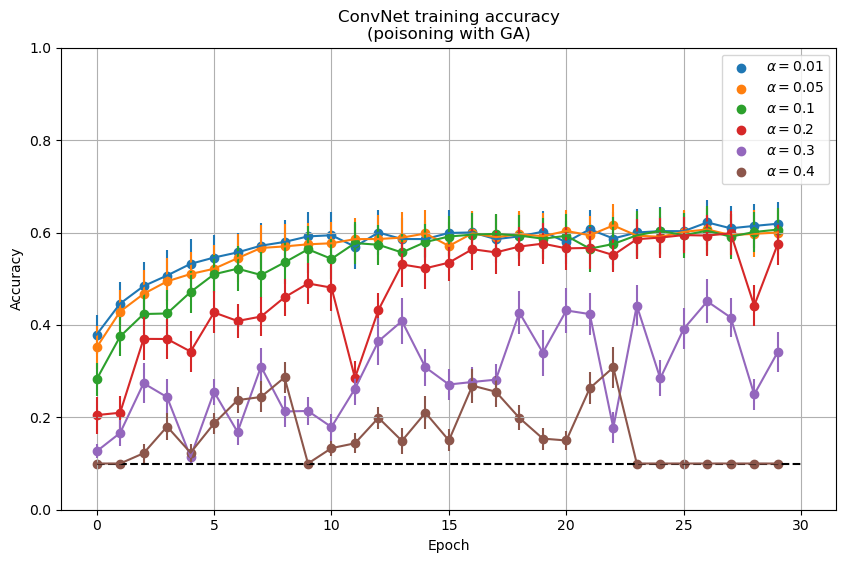

In [ ]:
display_poisoning_results(all_results)
save_figure("poisoning_convnet_sgd_with_ga")

### Unlearning vs Gradient Ascent data poisoning

In [ ]:
# Saving the results in case notebook gets interrupted
BACKUP = {}

def compute_unlearning_accuracies(
        model_factory: type[nn.Module] = ConvNet16,
        opt_cls: type[Optimizer] = SGD,
        poison_factor = np.array([0.4]), #np.array([0.2, 0.3, 0.4])
        quicktesting: bool = False,
    ) -> tuple[nn.Module, pd.DataFrame, dict[tuple[float, Unlearning], np.ndarray]]:
    """
    Compute an accuracy table and an per-epoch accuracy dict
    per poison factor and unlearning method.
    """
    epochs = 10
    training_hparams = dict(epochs = epochs)
    unlearn_method = [
        Unlearning.GRADIENT_DESCENT,
        Unlearning.GRADIENT_ASCENT,
        Unlearning.NEG_GRAD_PLUS,
        Unlearning.EUK,
        Unlearning.SCRUB,
    ]
    # Tuned for ConvNet16
    unlearn_hparams = {
        Unlearning.GRADIENT_DESCENT: dict(lr=5e-2, epochs=5),
        Unlearning.GRADIENT_ASCENT: dict(lr=1e-7, epochs=20),
        Unlearning.NEG_GRAD_PLUS: dict(lr=5e-2, beta=0.9999, epochs=20),
        Unlearning.EUK: dict(k=2, lr=5e-2, epochs=5),
        Unlearning.SCRUB: dict(lr=5e-3, max_steps=2, steps=3, epochs=5),
    }
    all_logs = {}
    rows = []
    for alpha in poison_factor:
        poisoned, poison_results = poison(
            model_factory,
            opt_cls=opt_cls,
            aggregator=Mean(),
            inversion_method=GradientAttack.ASCENT,
            poison_factor=alpha,
            training_hparams=training_hparams,
            quicktesting=quicktesting,
        )
        BACKUP[(alpha, 'poison_results')] = poison_results
        file_prefix = f"{unlearner._get_name()}_sgd_poison_{alpha}_epochs-{epochs}"
        save_model(poisoned, f"{file_prefix}.ckpt")
        forget_set = poison_results.poison_set
        num_byzantine = int(alpha / (1. - alpha) * batch_size)
        forget_set = Subset(
            poison_results.poison_set,
            # Poisons are identical at each step, so skip them in order to make
            # a smaller forget set
            torch.arange(0, len(forget_set), num_byzantine),
        )
        print(f"{len(forget_set)} poisons")
        
        for method in unlearn_method:
            unlearner, unlearn_results = unlearn(
                poisoned,
                forget_set,
                unlearning_method=method,
                unlearning_hparams=unlearn_hparams[method],
                quicktesting=quicktesting,
            )
            save_model(unlearner, f"{file_prefix}_{method}.ckpt")
            
            clear_output()
            logs = unlearn_results.unlearn_logs

            val_acc_per_step_per_epoch = torch.vstack([
                epoch_metrics['MetricTracker'].compute_all()['accuracy'].mean(dim=1)
                for epoch_metrics in logs.val_metrics
            ]).numpy(force=True)
            val_acc_per_epoch: Tensor = val_acc_per_step_per_epoch.mean(axis=1)
            best_val_epoch = np.argmax(val_acc_per_epoch)
            best_val_acc = val_acc_per_epoch[best_val_epoch]
            rows.append((alpha, str(method), best_val_acc, best_val_epoch))
            all_logs[(alpha, method)] = logs
    table = pd.DataFrame(
        rows,
        columns=['poison_factor', 'unlearning_method', 'best_accuracy', 'best_accuracy_epoch'],
    )
    return poisoned, table, all_logs

def display_unlearning_accuracies(
        all_logs: dict[tuple[float, Unlearning], Logs],
        baseline: float,
    ):
    plt.figure(figsize=(10, 6))
    min_acc = baseline
    max_step = 0
    for ((alpha, method), logs) in all_logs.items():
        val_acc_per_step_per_epoch = torch.vstack([
            epoch_metrics['MetricTracker'].compute_all()['accuracy'].mean(dim=1)
            for epoch_metrics in logs.val_metrics
        ]).numpy(force=True)
        val_acc_per_epoch = [min_acc] + list(val_acc_per_step_per_epoch.mean(axis=1))
        epoch_steps = np.cumsum([0] + [
            len(epoch_metrics['MetricTracker'].compute_all()['accuracy'])
            for epoch_metrics in logs.train_metrics
        ])
        if alpha == 0.0:
            plt.plot(
                epoch_steps, val_acc_per_epoch,
                label="No poisoning", linestyle="dotted", color='black',
            )
            max_acc = max(val_acc_per_epoch)
        else:
            plt.plot(epoch_steps, val_acc_per_epoch, label=rf"{method}")
        max_step = max(epoch_steps.max(), max_step)
    
    plt.hlines(
        min_acc, 0, max_step,
        linestyles='dashed', colors='red',
        label=fr"After poisoning ($\alpha=${alpha})", alpha=0.5,
    )
    plt.hlines(
        max_acc, 0, max_step,
        linestyles='dashed', colors='black', alpha=0.4,
    )
    plt.ylim(0.0, 1.0)
    plt.grid()

    plt.xlabel("Step")
    plt.ylabel("Validation accuracy")
    plt.title(f"Accuracy when unlearning")
    plt.suptitle(f"ConvNet16 poisoned with Gradient Ascent poisoning")
    plt.legend()
    plt.show()

    save_figure("poisoned_convnet_sgd_with_ga_unlearn_accuracy")

In [ ]:
poisoned, unlearning_acc_table, all_logs = compute_unlearning_accuracies(
    ConvNet16, opt_cls=SGD, quicktesting=False,
)
unlearning_acc_table

,poison_factor,unlearning_method,best_accuracy,best_accuracy_epoch
0,0.0,None,0.516599,3
1,0.2,None,0.455888,2
2,0.2,NegGrad+,0.640251,3
3,0.2,EUk,0.563028,4


In [ ]:
min_acc = compute_accuracy(poisoned)

In [ ]:
training_hparams = dict(epochs=5)
trained, train_results = train(
    ConvNet16,
    opt_cls=SGD,
    aggregator=Mean(),
    training_hparams=training_hparams,
    quicktesting=False,
)
all_logs[(0.0, None)] = train_results.train_logs
all_logs_ = {(alpha, m): r for ((alpha, m), r) in all_logs.items() if alpha == 0.4}

In [ ]:
display_unlearning_accuracies(all_logs_, min_acc)

### Assessing $m$-Krum's utility

We study the effect of using a robust aggregator on the model's test accuracy.

In [ ]:
def assess_krum(
        model_factory: type[nn.Module],
        training_hparams = dict(epochs=1),
        n_points: int = 11,
    ) -> tuple[float, pd.DataFrame]:

    def baseline() -> float:
        model, _ = train(
            model_factory,
            aggregator = Mean(),
            training_hparams = training_hparams,
            quicktesting=False,
        )
        return compute_accuracy(model)
    
    def eval_krum_with_poison_factor(tol: float) -> float:
        model, _ = train(
            model_factory,
            aggregator = Krum.with_learning_settings(batch_size, tol),
            training_hparams = training_hparams,
            quicktesting=False,
        )
        clear_output(wait=True)
        return compute_accuracy(model)
        
    base_acc = baseline()

    x_f = np.linspace(0.0, 0.4, n_points)
    y_accuracy = np.vectorize(eval_krum_with_poison_factor)(x_f)

    df = pd.DataFrame({'f': x_f, 'accuracy': y_accuracy})
    return base_acc, df

In [ ]:
base_acc, x_f_y_acc = assess_krum(ShuffleNetV2, training_hparams=dict(epochs=4))

Test epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

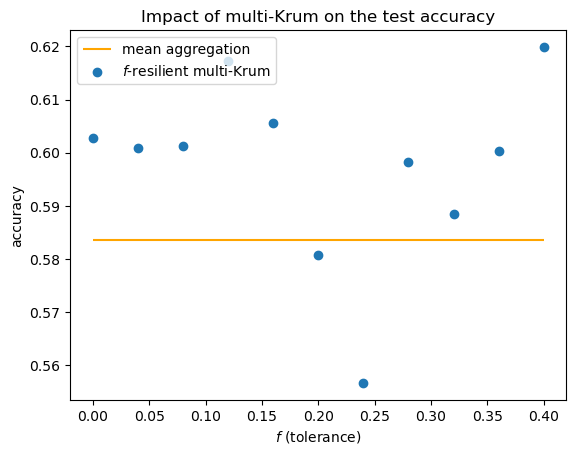

In [ ]:
def display_krum_assessment(base_acc: float, x_f_y_acc: pd.DataFrame):
    # TODO: error bars + statistical test
    x_f = x_f_y_acc['f']
    y_accuracy = x_f_y_acc['accuracy']
    plt.hlines(base_acc, min(x_f), max(x_f), label="mean aggregation", colors='orange')

    plt.scatter(x_f, y_accuracy, label=r"$f$-resilient multi-Krum")
    plt.xlabel(r"$f$ (tolerance)")
    plt.ylabel(r"accuracy")
    plt.legend(loc="upper left")
    plt.title(r"Impact of multi-Krum on the test accuracy")
    plt.show()

display_krum_assessment(base_acc, x_f_y_acc)
save_figure("krum_impact_of_accuracy_without_poisoning")

In [ ]:
print(f"Base accuracy (mean): {base_acc:.3}")
print(f"Krum accuracy:")
x_f_y_acc

Base accuracy (mean): 0.584
Krum accuracy:


,f,accuracy
0,0.00,0.6027
1,0.04,0.6009
2,0.08,0.6013
3,0.12,0.6173
4,0.16,0.6056
5,0.20,0.5807
6,0.24,0.5567
7,0.28,0.5983
8,0.32,0.5884
9,0.36,0.6004


When there is no poisoning, Krum incurs a minimal accuracy decrease (~3%) even in the most pessimistic learning settings. Since the accuracy also increases, we can tell with high statistical confidence that Krum does not decrease accuracy by a significant amount.

### Testing Krum against poisoning

Warning: this part takes a long time to run.

In [ ]:
def test_krum_against_poisoning(
        model_factory: type[nn.Module],
        opt_cls: type[Optimizer] = Adam,
        inversion_method = GradientAttack.ASCENT,
        quicktesting: bool = False,
    ) -> tuple[pd.DataFrame, dict[tuple[float, Unlearning], np.ndarray]]:
    """
    Compute an accuracy table and an per-epoch accuracy dict
    per poison factor and Krum parameters.
    """
    poison_factor = np.array([0.00, 0.05, 0.1, 0.2, 0.3, 0.4])
    tolerance = np.array([0.3])
    epochs = 6
    training_hparams = dict(epochs=epochs)
    accuracies = {}
    rows = []
    for alpha in poison_factor:
        num_clean = batch_size
        num_byzantine = int(alpha / (1. - alpha) * num_clean)
        for tol in tolerance:
            if num_byzantine == 0:
                poisoned, poison_results = train(
                    model_factory,
                    opt_cls=opt_cls,
                    aggregator=Krum.with_learning_settings(num_clean, tol),
                    training_hparams=training_hparams,
                    quicktesting=quicktesting,
                )
            else:
                poisoned, poison_results = poison(
                    model_factory,
                    opt_cls=opt_cls,
                    aggregator=Krum.with_learning_settings(num_clean, tol),
                    inversion_method=inversion_method,
                    poison_factor=alpha,
                    training_hparams=training_hparams,
                    quicktesting=quicktesting,
                )
            file_name = f"{poisoned._get_name()}_sgd_krum_{tol}_lie_{alpha}_epochs-{epochs}.ckpt"
            save_model(poisoned, file_name)
            clear_output(wait=True)
            logs = poison_results.train_logs

            val_acc_per_step_per_epoch = torch.vstack([
                epoch_metrics['MetricTracker'].compute_all()['accuracy'].mean(dim=1)
                for epoch_metrics in logs.train_metrics
            ]).numpy(force=True)
            val_acc_per_epoch: Tensor = val_acc_per_step_per_epoch.mean(axis=1)
            best_val_epoch = np.argmax(val_acc_per_epoch)
            best_val_acc = val_acc_per_epoch[best_val_epoch]
            rows.append((alpha, tol, best_val_acc, best_val_epoch))
            accuracies[(alpha, tol)] = val_acc_per_epoch
    table = pd.DataFrame(
        rows,
        columns=['poison_factor', 'tolerance', 'best_accuracy', 'best_accuracy_epoch'],
    )
    # TODO: add baselines without poisoning and without unlearning
    return table, accuracies

def display_krum_accuracies(
        accuracies: dict[tuple[float, Unlearning], np.ndarray],
        model_name='ConvNet16',
        opt_name='SGD',
        attack_name='GA',
    ):
    for ((alpha, tol), val_acc_per_epoch) in accuracies.items():
        plt.plot(val_acc_per_epoch, label=rf"\alpha={alpha} ($f=${tol})")
    
    # TODO: add baselines

    plt.xlabel("Epoch")
    plt.ylabel("Validation accuracy")
    plt.title(f"Accuracy with robust aggregation")
    plt.suptitle(f"{model_name} + {opt_name} + Krum")
    plt.legend()
    plt.show()
    save_figure(f"{model_name}_Krum_{opt_name}_accuracy_against_{attack_name}")

In [ ]:
krum_acc_table, krum_acc_dict = test_krum_against_poisoning(
    ConvNet16, opt_cls=SGD, inversion_method=GradientAttack.ASCENT,
)
krum_acc_table

Pipeline(settings=LearningSettings(criterion=CrossEntropyLoss(), aggregator=Krum(num_byzantine=5, num_selected=42), num_clean=50, num_byzantine=12), train_loader=Dataloader(<len=40000>), val_loader=Dataloader(<len=5000>), hparams=Hyperparams(lr=0.002, momentum=0.9, weight_decay=1e-05, max_lr=0.1, batch_size=50, epochs=6, num_classes=10, top_k=1, criterion=CrossEntropyLoss()), unlearning_hparams={<Unlearning.GRADIENT_DESCENT: 0>: {'lr': 0.002, 'epochs': 1}, <Unlearning.NOISY_GRADIENT_DESCENT: 2>: {'lr': 0.002, 'epochs': 1, 'noise_scale': np.float64(0.00031622776601683794)}, <Unlearning.GRADIENT_ASCENT: 1>: {'lr': 1e-05, 'epochs': 1}, <Unlearning.NEG_GRAD_PLUS: 3>: {'lr': 0.002, 'beta': 0.999, 'epochs': 6}, <Unlearning.CFK: 4>: {'k': 6, 'lr': 0.002, 'epochs': 3}, <Unlearning.EUK: 5>: {'k': 6, 'lr': 0.002, 'epochs': 3}, <Unlearning.SCRUB: 6>: {'max_steps': 1, 'steps': 1, 'alpha': 0.1, 'beta': 0.01, 'gamma': 0.9}})
Poisoning GradientInverter(method=Little Is Enough, estimator=ShadowGradien

Train epochs:   0%|          | 0/6 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 6249.77it/s, accuracy=0.1, avg_loss=2.4]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 6313.85it/s, accuracy=0.1, avg_loss=2.9]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 6267.84it/s, accuracy=0.1, avg_loss=2.61]


Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

In [ ]:
display_krum_accuracies(
    krum_acc_dict,
    model_name='ConvNet16', opt_name='SGD', attack_name='GA',
)

In [ ]:
# FIXME: try Min-Sum instead of vanilla LIE against Krum

### Other experiments

#### Mean + SGD vs LIE (Min-Sum)

In [ ]:
def test_against_lie(
        model_factory: type[nn.Module],
        opt_cls: type[Optimizer] = SGD,
        quicktesting: bool = False,
    ) -> tuple[pd.DataFrame, dict[tuple[float, Unlearning], np.ndarray]]:
    """
    Compute an accuracy table and an per-epoch accuracy dict
    per poison factor and Krum parameters.
    """
    poison_factor = np.array([0.00, 0.05, 0.1, 0.2, 0.3, 0.4])
    accuracies = {}
    rows = []
    epochs = 6
    training_hparams = dict(epochs=epochs)
    for alpha in poison_factor:
        num_clean = batch_size
        num_byzantine = int(alpha / (1. - alpha) * num_clean)
        if num_byzantine == 0:
            poisoned, poison_results = train(
                model_factory,
                opt_cls=opt_cls,
                aggregator=Mean(),
                training_hparams=training_hparams,
                quicktesting=quicktesting,
            )
        else:
            poisoned, poison_results = poison(
                model_factory,
                opt_cls=opt_cls,
                aggregator=Mean(),
                # FIXME: use Min-Sum instead of vanilla LIE
                inversion_method=GradientAttack.LITTLE_IS_ENOUGH,
                poison_factor=alpha,
                training_hparams=training_hparams,
                quicktesting=quicktesting,
            )
        file_name = f"{poisoned._get_name()}_sgd_mean_lie_{alpha}_epochs-{epochs}"
        save_model(poisoned, file_name)
        clear_output(wait=True)
        logs = poison_results.train_logs

        val_acc_per_step_per_epoch = torch.vstack([
            epoch_metrics['MetricTracker'].compute_all()['accuracy'].mean(dim=1)
            for epoch_metrics in logs.train_metrics
        ]).numpy(force=True)
        val_acc_per_epoch: Tensor = val_acc_per_step_per_epoch.mean(axis=1)
        best_val_epoch = np.argmax(val_acc_per_epoch)
        best_val_acc = val_acc_per_epoch[best_val_epoch]
        rows.append((alpha, best_val_acc, best_val_epoch))
        accuracies[alpha] = val_acc_per_epoch
    table = pd.DataFrame(
        rows,
        columns=['poison_factor', 'best_accuracy', 'best_accuracy_epoch'],
    )
    return table, accuracies

def display_lie_accuracies(
        accuracies: dict[tuple[float, Unlearning], np.ndarray],
        model_name = "ConvNet16",
        opt_name = "SGD",
    ):
    for ((alpha, tol), val_acc_per_epoch) in accuracies.items():
        plt.plot(val_acc_per_epoch, label=rf"\alpha={alpha} ($f=${tol})")
    
    # TODO: add baselines

    plt.xlabel("Epoch")
    plt.ylabel("Validation accuracy")
    plt.title(f"Accuracy with no defense against LIE")
    plt.suptitle(f"{model_name} + Krum")
    plt.legend()
    plt.show()
    save_figure(f"{model_name}_{opt_name}_Krum_LIE_accuracy")

In [ ]:
poison_acc_table, poison_acc_dict = test_against_lie(ConvNet16, SGD)
poison_acc_table

In [ ]:
display_lie_accuracies(poison_acc_dict, "ConvNet16", "SGD")

#### Mean + Adam vs LIE (Min-Sum)

In [ ]:
poison_acc_table, poison_acc_dict = test_against_lie(ConvNet16, Adam)
poison_acc_table

In [ ]:
display_lie_accuracies(poison_acc_dict, "ConvNet16", "Adam")

## Testing gradient estimation with auxiliary dataset

We test the estimation quality of the average clean gradient.

In [ ]:
def eval_gradient_estimation(
        model: nn.Module,
        train: bool = True,
        momentum: float = 0.9,
    ) -> list[float]:
    model = deepcopy(model)
    model.train(train)
    estimator = ShadowGradientEstimator(aux_loader, momentum=momentum)
    omniscient = OmniscientGradientEstimator()

    mini_train_set = random_split(training_data, [0.4, 0.6])[0]
    mini_train_loader = DataLoader(mini_train_set, batch_size=batch_size)
    optimizer = Adam(model.parameters())

    scores = []
    for X, y in mini_train_loader:
        X, y = X.to(BEST_DEVICE), y.to(BEST_DEVICE)
        criterion(model(X), y).backward()
        g_true = omniscient.average_clean_gradient(model, criterion)
        if train:
            optimizer.step()
        optimizer.zero_grad()

        g_pred = estimator.average_clean_gradient(model, criterion)

        cos_sim = torch.cosine_similarity(g_true, g_pred, dim=0).item()
        scores.append(cos_sim)
    return scores

def show_scores(scores: list[float], ax: plt.Axes):
    ax.plot(scores)
    ax.hlines(np.mean(scores), 0, len(scores), color='orange')
    ax.set_xlabel("Step")
    ax.set_ylabel("Cosine similarity")


In [ ]:
def gradient_estimation_comparison(model: nn.Module):
    fig, axes = plt.subplots(1, 5, sharey=True)
    fig.set_figwidth(12)

    momentum = 0.9
    scores_1 = eval_gradient_estimation(model, train=False, momentum=momentum)
    show_scores(scores_1, ax=axes[0])
    axes[0].set_title(f"No training\nmomentum: {momentum}")

    scores_2 = eval_gradient_estimation(model, momentum=momentum)
    show_scores(scores_2, ax=axes[1])
    axes[1].set_title(f"Training\nmomentum: {momentum}")

    momentum = 0.7
    scores_3 = eval_gradient_estimation(model, train=False, momentum=momentum)
    show_scores(scores_3, ax=axes[2])
    axes[2].set_title(f"No training\nmomentum: {momentum}")

    scores_4 = eval_gradient_estimation(model, momentum=momentum)
    show_scores(scores_4, ax=axes[3])
    axes[3].set_title(f"Training\nmomentum: {momentum}")

    scores_5 = eval_gradient_estimation(model, momentum=0.0)
    show_scores(scores_5, ax=axes[4])
    axes[4].set_title(f"Training\nno momentum")

    fig.suptitle("True batch gradient vs. estimated average gradient")
    fig.tight_layout()

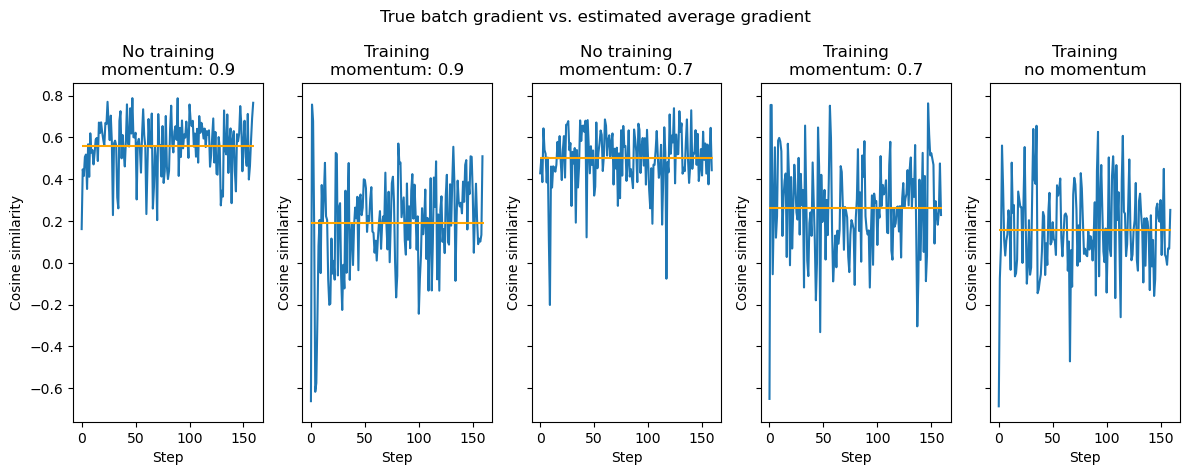

In [ ]:
model = train(
    ConvNet16,
    opt_cls=Adam,
    training_hparams=dict(epochs=1),
)
gradient_estimation_comparison(model)